In [1]:
import os, math, multiprocessing, itertools, time, datetime

import pandas as pd
import numpy as np

import essentia.standard as es
import matplotlib.pyplot as plt

from random import randrange, sample, random
from functools import partial

from scipy import stats

from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit, GridSearchCV, GroupKFold, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_classif
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# DATASET

In [7]:
def split_dataset(dataset, random_state, train_dataset_size, validation_dataset_size):
    gss = GroupShuffleSplit(n_splits=10, train_size=train_dataset_size, random_state=random_state)
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_idx, test_validation_idx in gss.split(original_dataset, original_dataset['emotion'], original_dataset['speaker']):
        train_dataset = dataset.iloc[train_idx]
        test_validation_dataset = dataset.iloc[test_validation_idx]
    if validation_dataset_size == 0:
        return train_dataset, train_dataset, test_validation_dataset
        
    gss = GroupShuffleSplit(n_splits=1, train_size=validation_dataset_size / (1 - train_dataset_size), random_state=random_state)
    for validation_idx, test_idx in gss.split(test_validation_dataset, test_validation_dataset['emotion'], test_validation_dataset['speaker']):
        test_dataset = test_validation_dataset.iloc[test_idx]
        validation_dataset = test_validation_dataset.iloc[validation_idx]
    
    augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
    train_dataset = pd.concat([train_dataset, augmented_dataset])
    return train_dataset, validation_dataset, test_dataset

def split_dataset_speaker_dependent(dataset, random_state, train_dataset_size, validation_dataset_size):
    sss = StratifiedShuffleSplit(n_splits=10, train_size=train_dataset_size, random_state=random_state)
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_idx, test_validation_idx in sss.split(original_dataset, original_dataset['emotion']):
        train_dataset = dataset.iloc[train_idx]
        test_validation_dataset = dataset.iloc[test_validation_idx]
    if validation_dataset_size == 0:
        return train_dataset, train_dataset, test_validation_dataset
        
    sss = StratifiedShuffleSplit(n_splits=1, train_size=validation_dataset_size / (1 - train_dataset_size), random_state=random_state)
    for validation_idx, test_idx in sss.split(test_validation_dataset, test_validation_dataset['emotion']):
        test_dataset = test_validation_dataset.iloc[test_idx]
        validation_dataset = test_validation_dataset.iloc[validation_idx]
        
    augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
    train_dataset = pd.concat([train_dataset, augmented_dataset])
    return train_dataset, validation_dataset, test_dataset

emotion_dictionary = {
    'happiness': 'radość',
    'sadness': 'smutek',
    'surprise': 'zaskoczenie',
    'fear': 'lęk',
    'anger': 'gniew',
    'disgust': 'obrzydzenie',
    'neutral': 'neutralny'
}

In [18]:
catalogue = pd.read_csv('./data_catalogue.csv', sep=';')

dataset = catalogue
dataset = dataset.reset_index()

In [19]:
corpora = dataset['dataset'].unique()
original_dataset = dataset[(dataset['augmentation'] == 'no') & (dataset['emotion'].isin(['anger', 'sadness', 'happiness', 'fear', 'disgust']))]
sizes = np.array([len(original_dataset[original_dataset['dataset'] == corpus]) for corpus in corpora])
min_size = sizes.min()
samples = []

for corpus in corpora:
    corpus_dataset = original_dataset[original_dataset['dataset'] == corpus]
    if (len(corpus_dataset) > min_size):
        n = int(min_size / len(corpus_dataset['emotion'].unique()) / len(corpus_dataset['sex'].unique()))
        corpus_sample = corpus_dataset.groupby(['emotion', 'sex'], as_index=False, group_keys=False).apply(lambda data: data.sample(n=n, random_state=8))
    else:
        corpus_sample = corpus_dataset
    
    augmented_sample = dataset[(dataset['original_id'].isin(corpus_sample['id'])) & (dataset['augmentation'] != 'no')]
    samples.append(pd.concat([corpus_sample, augmented_sample]))

dataset = pd.concat(samples)
dataset = dataset.reset_index()
dataset = dataset.drop('level_0', axis=1)

In [172]:
train_dataset, validation_dataset, test_dataset = split_dataset(dataset, 8, 0.66, 0.12)

In [173]:
train_dataset['augmentation'].value_counts()

pitch_shift     1674
time_stretch    1674
no               837
Name: augmentation, dtype: int64

# FEATURE EXTRACTION

In [6]:
def normalize(audio):
    audio -= audio.mean()
    audio /= audio.std()
    return audio

def trim(audio, percentage):
    absolute = np.abs(audio)
    threshold = (absolute.max() - absolute.min()) * percentage / 100
    for start, sample in enumerate(absolute):
        if sample > threshold:
            break
    for end, sample in reversed(list(enumerate(absolute))):
        if sample > threshold:
            break
    audio = audio[start:end]
    return audio

def preprocess(audio, low_pass, high_pass):
    lowpass = es.LowPass(cutoffFrequency=low_pass)
    audio = lowpass(audio)
    if high_pass != 0:
        highpass = es.HighPass(cutoffFrequency=high_pass)
        audio = highpass(audio)
    audio = trim(audio, 5)
    audio = normalize(audio)
    return audio

def essentia_mfcc(filepath, options):
    window = es.Windowing(type=options['windowing'], size=options['frame_size'])
    spectrum = es.Spectrum(size=options['frame_size'])
    mfcc = es.MFCC(
        type=options['type'],
        warpingFormula=options['warping_formula'],
        weighting=options['weighting'],
        highFrequencyBound=options['high_frequency_bound'],
        numberBands=options['number_bands'],
        numberCoefficients=options['number_coefficients'],
        normalize=options['normalize'],
        dctType=options['dct_type'],
        logType=options['log_type'],
        liftering=options['liftering'],
        lowFrequencyBound=options['low_frequency_bound'],
        inputSize=(int(options['frame_size'] / 2) + 1))
    
    loader = es.MonoLoader(filename=filepath)
    audio = loader()
    audio = preprocess(audio, options['low_pass'], options['high_pass'])
    mfccs = []
    for frame in es.FrameGenerator(audio,
            frameSize=options['frame_size'],
            hopSize=int(options['frame_size'] / 4),
            startFromZero=True,
            validFrameThresholdRatio=1):
        spect = spectrum(window(frame))
        _, mfcc_coeffs = mfcc(spect)
        mfccs.append(mfcc_coeffs)
    mfccs = np.array(mfccs).T
    coeffs = {
        'mfcc': mfccs.shape[0]
    }
    return mfccs, coeffs

def essentia_pitch(filepath, options):
    window = es.Windowing(type='hann', size=1102)
    spectrum = es.Spectrum(size=1102)
    pitch = es.PitchYinFFT(
        frameSize=1102,
        interpolate=options['interpolate'],
        maxFrequency=options['max_frequency'],
        minFrequency=options['min_frequency'],
        tolerance=options['tolerance'])
    
    loader = es.MonoLoader(filename=filepath)
    audio = loader()
    audio = preprocess(audio, 1000, 0)
    pitches = []
    for frame in es.FrameGenerator(audio,
            frameSize=1102,
            hopSize=int(1102 / 4),
            startFromZero=True,
            validFrameThresholdRatio=1):
        spect = spectrum(window(frame))
        pitch_value, _ = pitch(spect)
        pitches.append(pitch_value)
    pitches = np.expand_dims(np.array(pitches), axis=0)
    coeffs = {
        'pitch': pitches.shape[0]
    }
    return pitches, coeffs

def essentia_features(filepath, options):
    window = es.Windowing(type=options['windowing'], size=options['frame_size'])
    spectrum = es.Spectrum(size=options['frame_size'])
    mfcc = es.MFCC(
        type=options['type'],
        warpingFormula=options['warping_formula'],
        weighting=options['weighting'],
        highFrequencyBound=options['high_frequency_bound'],
        numberBands=options['number_bands'],
        numberCoefficients=options['number_coefficients'],
        normalize=options['normalize'],
        dctType=options['dct_type'],
        logType=options['log_type'],
        liftering=options['liftering'],
        lowFrequencyBound=options['low_frequency_bound'],
        inputSize=(int(options['frame_size'] / 2) + 1))
    zcr = es.ZeroCrossingRate()
    pitch = es.PitchYinFFT(frameSize=options['frame_size'])
    flux = es.Flux()
    
    loader = es.MonoLoader(filename=filepath)
    audio = loader()
    audio = preprocess(audio, options['low_pass'], options['high_pass'])
    mfccs = []
    zcrs = []
    zcrs_delta = []
    zcrs_delta_delta = []
    pitches = []
    pitches_delta = []
    pitches_delta_delta = []
    fluxes = []
    fluxes_delta = []
    fluxes_delta_delta = []
    for frame in es.FrameGenerator(audio,
            frameSize=options['frame_size'],
            hopSize=int(options['frame_size'] / 4),
            startFromZero=True,
            validFrameThresholdRatio=1):
        spect = spectrum(window(frame))
        _, mfcc_coeffs = mfcc(spect)
        
        pitch_value, _ = pitch(spect)        
        pitch_delta = pitch_value - pitches[len(pitches) - 1] if len(pitches) > 0 else 0
        pitch_delta_delta = pitch_delta - pitches_delta[len(pitches_delta) - 1] if len(pitches_delta) > 0 else 0
        
        flux_value = flux(spect)
        flux_delta = flux_value - fluxes[len(fluxes) - 1] if len(fluxes) > 0 else 0
        flux_delta_delta = flux_delta - fluxes_delta[len(fluxes_delta) - 1] if len(fluxes_delta) > 0 else 0
        
        zcr_value = zcr(frame)
        zcr_delta = zcr_value - zcrs[len(zcrs) - 1] if len(zcrs) > 0 else 0
        zcr_delta_delta = zcr_delta - zcrs_delta[len(zcrs_delta) - 1] if len(zcrs_delta) > 0 else 0
        
        mfccs.append(mfcc_coeffs)
        pitches.append(pitch_value)
        pitches_delta.append(pitch_delta)
        pitches_delta_delta.append(pitch_delta_delta)
        
        fluxes.append(flux_value)
        fluxes_delta.append(flux_delta)
        fluxes_delta_delta.append(flux_delta_delta)
        
        zcrs.append(zcr_value)
        zcrs_delta.append(zcr_delta)
        zcrs_delta_delta.append(zcr_delta_delta)
        
    mfccs = np.array(mfccs).T
    zcrs = np.expand_dims(np.array(zcrs), axis=0)
    zcrs_delta = np.expand_dims(np.array(zcrs_delta), axis=0)
    zcrs_delta_delta = np.expand_dims(np.array(zcrs_delta_delta), axis=0)
    
    pitches = np.expand_dims(np.array(pitches), axis=0)
    pitches_delta = np.expand_dims(np.array(pitches_delta), axis=0)
    pitches_delta_delta = np.expand_dims(np.array(pitches_delta_delta), axis=0)
    
    fluxes = np.expand_dims(np.array(fluxes), axis=0)
    fluxes_delta = np.expand_dims(np.array(fluxes_delta), axis=0)
    fluxes_delta_delta = np.expand_dims(np.array(fluxes_delta_delta), axis=0)

    coeffs = {
        'mfcc': mfccs.shape[0],
        'flux': fluxes.shape[0],
        'flux_delta': fluxes_delta.shape[0],
        'flux_delta_delta': fluxes_delta_delta.shape[0],
        'pitch': pitches.shape[0],
        'pitch_delta': pitches_delta.shape[0],
        'pitch_delta_delta': pitches_delta_delta.shape[0],
        'zcr': zcrs.shape[0],
        'zcr_delta': zcrs_delta.shape[0],
        'zcr_delta_delta': zcrs_delta_delta.shape[0]
    }
    return np.concatenate((mfccs, fluxes, fluxes_delta, fluxes_delta_delta, pitches, pitches_delta, pitches_delta_delta, zcrs, zcrs_delta, zcrs_delta_delta)), coeffs

def get_raw_features(dataset, options):
    raw_features = []
    for index, row in dataset.iterrows():
        features, _ = essentia_features(row['filepath'], options)
        raw_features.append(features)
    return raw_features

def get_feature_blocks(raw_features, block_number, overlap):
    all_blocks = []
    for feature in raw_features:
        block_size = math.floor((feature.shape[1] - overlap) / block_number + overlap)
        blocks = [np.asarray(feature[:, i : i + block_size]) for i in range(0, feature.shape[1], block_size - overlap)]
        while len(blocks) > block_number:
            blocks[len(blocks) - 2] = np.concatenate((blocks[len(blocks) - 2], blocks[len(blocks) - 1]), axis=1)
            blocks.pop()

        blocks_features = []
        for block in blocks:
            avg_stat = []
            std_stat = []
            median_stat = []
            q1_stat = []
            q2_stat = []
            min_stat = []
            max_stat = []
            for feature in block:
                avg_stat.append(feature.mean())
                std_stat.append(feature.std())
                median_stat.append(np.median(feature))
                q1_stat.append(np.percentile(feature, 25))
                q2_stat.append(np.percentile(feature, 75))
                min_stat.append(feature.min())
                max_stat.append(feature.max())
            features = np.concatenate([avg_stat, std_stat, median_stat, q1_stat, q2_stat, min_stat, max_stat])
            blocks_features.append(features)    
        all_blocks.append(blocks_features)
    
    return np.asarray(all_blocks).transpose(1, 0, 2)

def export_row_features(index):
    row = catalogue.iloc[index]
    features, _ = essentia_features(row['filepath'], options)
    raw_features = [features]

    small_block_features = get_feature_blocks(raw_features, 10, 2)
    big_block_features = get_feature_blocks(raw_features, 3, 4)
    single_block_features = get_feature_blocks(raw_features, 1, 0)

    final_features = np.concatenate([small_block_features, big_block_features, single_block_features])

    name, extension = os.path.splitext(os.path.basename(row['filepath']))
    directory_path = './features/' + row['dataset'] + '/'
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    filepath = directory_path + name + '_features.npy'
    np.save(filepath, final_features)

def export_features():
    catalogue['feature_file'] = None
    pool = multiprocessing.Pool()
    pool.map(export_row_features, range(len(dataset)))
    pool.close()
    pool.join()
    
    for index, row in catalogue.iterrows():
        name, extension = os.path.splitext(os.path.basename(row['filepath']))
        directory_path = './features/' + row['dataset'] + '/'
        filepath = directory_path + name + '_features.npy'
        catalogue.at[index, 'feature_file'] = filepath
        
def import_dataset_features(dataset):
    dataset_features = []
    for index, row in dataset.iterrows():
        dataset_features.append(np.load(row['feature_file']))
    dataset_features = np.concatenate(dataset_features, axis=1)
    
    small_block_features = dataset_features[0:10]
    big_block_features = dataset_features[10:13]
    single_block_features = np.expand_dims(dataset_features[13], axis=0)
    
    return small_block_features, big_block_features, single_block_features

def get_feature_names(mfcc_number):
    base_names = ['flux', 'flux_delta', 'flux_delta_delta', 'pitch', 'pitch_delta', 'pitch_delta_delta', 'zcr', 'zcr_delta', 'zcr_delta_delta']
    stat_names = ['avg', 'std', 'median', 'q1', 'q2', 'min', 'max']
    mfcc_names = ['mfcc_' + str(i) for i in range(0, mfcc_number)]
    base_names = mfcc_names + base_names
    
    feature_names = []
    for base_name in base_names:
        for stat_name in stat_names:
            feature_names.append(stat_name + '_' + base_name)
    return feature_names

def options_from_row(row):
    options = {}
    columns = row.index
    columns = np.delete(columns, [len(columns) - 3, len(columns) - 2, len(columns) - 1])
    for column in columns:
        if type(row[column]).__module__ == 'numpy': 
            options[column] = row[column].item()
        else:
            options[column] = row[column]
    return options

def split_features(train_dataset, validation_dataset, test_dataset, small_block_features, big_block_features, single_block_features):
    train_small_block_features = small_block_features[..., train_dataset.index, :]
    validation_small_block_features = small_block_features[..., validation_dataset.index, :]
    test_small_block_features = small_block_features[..., test_dataset.index, :]

    train_big_block_features = big_block_features[..., train_dataset.index, :]
    validation_big_block_features = big_block_features[..., validation_dataset.index, :]
    test_big_block_features = big_block_features[..., test_dataset.index, :]

    train_single_block_features = single_block_features[..., train_dataset.index, :]
    validation_single_block_features = single_block_features[..., validation_dataset.index, :]
    test_single_block_features = single_block_features[..., test_dataset.index, :]
    
    train_input = np.concatenate((train_small_block_features, train_big_block_features, train_single_block_features))
    validation_input = np.concatenate((validation_small_block_features, validation_big_block_features, validation_single_block_features))
    test_input = np.concatenate((test_small_block_features, test_big_block_features, test_single_block_features))
    
    return train_input, validation_input, test_input

In [7]:
class Specimen:
    def __init__(self, classifier, train_dataset, test_dataset, options_set):
        self.classifier = classifier
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.options_set = options_set
        self.option_names = list(options_set.keys())
        self.chromosome = []
        
        self.accuracy = None
        
    def init_random(self):
        for option_index, option_name in enumerate(self.option_names):
            self.add_random_gene()
            
    def init_ready(self, options, accuracy):
        self.accuracy = accuracy
        self.chromosome = []
        for option in options:
            self.chromosome.append(self.options_set[option].index(options[option]))
    
    def get_options(self):
        options = dict.fromkeys(self.options_set.keys(), None)
        for option_index, option_name in enumerate(self.option_names):
            options[option_name] = self.options_set[option_name][self.chromosome[option_index]]
        return options
    
    def calculate_fitness(self):
        options = self.get_options()
        try:
            train_raw_features = get_raw_features(self.train_dataset, options)
            test_raw_features = get_raw_features(self.test_dataset, options)
            train_features = get_feature_blocks(train_raw_features, 1, 0)[0]
            test_features = get_feature_blocks(test_raw_features, 1, 0)[0]
        except RuntimeError:
            self.accuracy = -1
            return
        
        self.classifier.fit(train_features, self.train_dataset['emotion'])
        predicted = self.classifier.predict(test_features)
        self.accuracy = accuracy_score(predicted, self.test_dataset['emotion'])
    
    def get_fitness(self):
        return self.accuracy
        
    def add_gene(self, gene):
        self.chromosome.append(gene)
        
    def add_random_gene(self):
        option_name = self.option_names[len(self.chromosome)]
        values_number = len(self.options_set[option_name])
        random_gene = randrange(values_number)
        self.add_gene(random_gene)
        
    def get_gene(self, index):
        return self.chromosome[index]
    
    def equals(self, other_specimen):
        for index, gene in enumerate(self.chromosome):
            if gene != other_specimen.chromosome[index]:
                return False
        return True
    
    def to_string(self):
        return ''.join(str(x) for x in self.chromosome)

class GeneticAlgorithm:
    def __init__(self, classifier, population_size, crossover_possibility, mutation_possibility, tournament_size, history, train_dataset, test_dataset, options_set):
        self.classifier = classifier
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.options_set = options_set
        self.option_names = list(options_set.keys())
        
        self.population_size = population_size
        self.crossover_possibility = crossover_possibility
        self.mutation_possibility = mutation_possibility
        self.tournament_size = tournament_size
        self.current_iteration = 0
        self.population = []
        self.history = history
        
        self.init_population()
        
    def init_population(self):
        for i in range(0, self.population_size):
            specimen = self.create_specimen()
            specimen.init_random()
            specimen = self.find_in_history(specimen)
            if not self.exists(self.population, specimen) and specimen.accuracy != -1:
                self.population.append(specimen)
            else:
                i -= 1
                
        self.calculate_population_fitness(self.population, 8)
                
    def calculate_chunk_fitness(self, chunk, output):
        for index, specimen in enumerate(chunk):
            specimen.calculate_fitness()
            output[specimen.to_string()] = specimen.accuracy
                
    def calculate_population_fitness(self, population, cores):
        unprepared = np.asarray([specimen for specimen in population if specimen.get_fitness() is None])
        manager = multiprocessing.Manager()
        output = manager.dict()
        chunks = np.array_split(unprepared, cores)
        jobs = []
        for index, chunk in enumerate(chunks):
            p = multiprocessing.Process(target=self.calculate_chunk_fitness, args=(chunk, output))
            jobs.append(p)
            p.start()

        for proc in jobs:
            proc.join()
        
        for specimen in unprepared:
            specimen.accuracy = output[specimen.to_string()]
        
    def iteration(self):
        self.current_iteration += 1
        new_population = []
        parents = self.tournament_selection(5)
        pairs = list(itertools.combinations(parents, 2))
        for pair in pairs:
            if random() <= self.crossover_possibility: 
                offspring1, offspring2 = self.crossover(pair[0], pair[1])
                offspring1 = self.find_in_history(offspring1)
                offspring2 = self.find_in_history(offspring2)
                if not self.exists(new_population, offspring1):
                    new_population.append(offspring1)
                if not self.exists(new_population, offspring2):
                    new_population.append(offspring2)
                
        for parent in parents:
            if random() <= self.mutation_possibility:
                mutated = self.mutation(parent)
                mutated = self.find_in_history(mutated)
                if not self.exists(new_population, mutated):
                    new_population.append(mutated)
        
        for i in range(0, 3):
            if not self.exists(new_population, parents[i]):
                new_population.append(parents[i])
            
        self.calculate_population_fitness(new_population, 8)
        new_population.sort(key=lambda specimen: specimen.get_fitness(), reverse=True)
        self.population = new_population[:self.population_size]
    
    def best(self):
        return max(self.population, key=lambda specimen: specimen.get_fitness())
    
    def create_specimen(self):
        specimen = Specimen(self.classifier, self.train_dataset, self.test_dataset, self.options_set)
        return specimen
        
    def crossover(self, parent1, parent2):
        offspring1 = self.create_specimen()
        offspring2 = self.create_specimen()
        for option_index, option_name in enumerate(self.option_names):
            if random() < 0.5:
                offspring1.add_gene(parent1.get_gene(option_index))
                offspring2.add_gene(parent2.get_gene(option_index))
            else:
                offspring1.add_gene(parent2.get_gene(option_index))
                offspring2.add_gene(parent1.get_gene(option_index))
        return offspring1, offspring2
    
    def mutation(self, specimen):
        mutated = self.create_specimen()
        for option_index, option_name in enumerate(self.option_names):
            if random() < 0.5:
                mutated.add_random_gene()
            else:
                mutated.add_gene(specimen.get_gene(option_index))
        return mutated
        
    def tournament_selection(self, size):
        parents = []
        old_population = [specimen for specimen in self.population]
        while len(old_population) > self.tournament_size and len(parents) < size:
            tournament = sample(old_population, self.tournament_size)
            winner = max(tournament, key=lambda specimen: specimen.get_fitness())
            parents.append(winner)
            old_population.remove(winner)
        if len(parents) < size:
            parents[len(parents):size] = old_population[:size-len(parents)]
        parents.sort(key=lambda specimen: specimen.get_fitness(), reverse=True)
        return parents
        
    def find_in_history(self, specimen):
        key = specimen.to_string()
        if key in self.history:
            return self.history[key]
        else:
            self.history[key] = specimen
            return specimen
    
    def exists(self, population, specimen):
        for existing_specimen in population:
            if specimen.equals(existing_specimen):
                return True
        return False

In [8]:
mfcc_options_set = {
    'frame_size': [512, 756, 1024, 1102],
    'windowing': ['hamming', 'hann'],
    'warping_formula': ['slaneyMel', 'htkMel'],
    'log_type': ['natural', 'dbpow', 'dbamp', 'log'],
    'dct_type': [2, 3],
    'normalize': ['unit_sum', 'unit_tri', 'unit_max'],
    'high_frequency_bound': [6000, 8000, 16000, 20000],
    'number_bands': [26, 128],
    'number_coefficients': [10, 13, 20, 40, 80, 120],
    'weighting': ['warping', 'linear'],
    'type': ['magnitude', 'power'],
    'liftering': [0, 22, 10, 40, 100],
    'low_frequency_bound': [0, 50, 100, 200, 500],
    'low_pass': [0, 1000, 2000, 5000, 7000],
    'high_pass': [0, 8000, 15000, 20000, 100000]
}

In [9]:
results = pd.read_csv('./results.csv', sep=';')

In [8]:
history = {}
total_time = 0

In [141]:
for index, row in results.iterrows():
    specimen = Specimen(classifier, train_dataset, validation_dataset, pitch_options_set)
    options = options_from_row(row)
    specimen.init_ready(options, row['accuracy'])
    history[specimen.to_string()] = specimen

In [23]:
os.system("taskset -p 0xff %d" % os.getpid())
accuracies = []
classifier = SVC()

genetic_algorithm = GeneticAlgorithm(classifier, 10, 0.7, 0.5, 3, history, train_dataset, validation_dataset, mfcc_options_set)
start_time = time.time()
for i in range(0, 50):
    genetic_algorithm.iteration()
    best = genetic_algorithm.best()
    
    print()
    print(best.get_options())
    print(best.accuracy)
    accuracies.append(best.accuracy)
total_time += time.time() - start_time
print('Total time:', datetime.timedelta(seconds=(total_time)))


{'frame_size': 1102, 'windowing': 'hamming', 'warping_formula': 'slaneyMel', 'log_type': 'dbamp', 'dct_type': 2, 'normalize': 'unit_max', 'high_frequency_bound': 6000, 'number_bands': 128, 'number_coefficients': 120, 'weighting': 'linear', 'type': 'power', 'liftering': 100, 'low_frequency_bound': 0, 'low_pass': 7000, 'high_pass': 8000}
0.36153846153846153

{'frame_size': 1102, 'windowing': 'hamming', 'warping_formula': 'slaneyMel', 'log_type': 'dbamp', 'dct_type': 3, 'normalize': 'unit_max', 'high_frequency_bound': 6000, 'number_bands': 128, 'number_coefficients': 120, 'weighting': 'warping', 'type': 'power', 'liftering': 100, 'low_frequency_bound': 0, 'low_pass': 7000, 'high_pass': 8000}
0.36538461538461536

{'frame_size': 1102, 'windowing': 'hamming', 'warping_formula': 'slaneyMel', 'log_type': 'dbamp', 'dct_type': 3, 'normalize': 'unit_max', 'high_frequency_bound': 6000, 'number_bands': 128, 'number_coefficients': 120, 'weighting': 'linear', 'type': 'power', 'liftering': 100, 'low_

In [24]:
np.save('accuracies_genetic_algorithm.npy', np.asarray(accuracies))

In [25]:
np.save('total_time_genetic_algorithm.npy', np.asarray([total_time]))

In [26]:
np.save('history.npy', np.asarray(history))

In [27]:
np.save('population.npy', np.asarray(genetic_algorithm.population))

In [28]:
np.save('iteration_count.npy', np.asarray([genetic_algorithm.current_iteration]))

In [27]:
accuracies = np.load('accuracies_genetic_algorithm.npy')

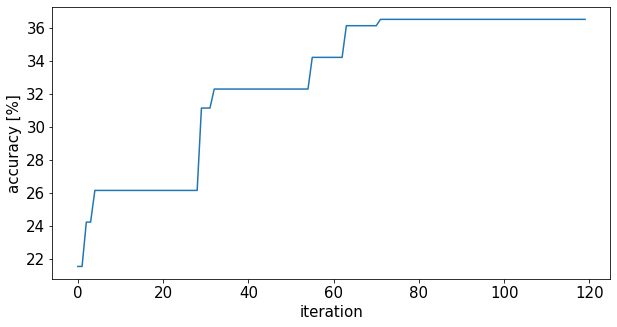

In [30]:
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10, 5))
percentages = [accuracy * 100 for accuracy in accuracies]
plt.plot(percentages)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('accuracy [%]', fontsize=15)
#plt.title('przykładowy przebieg algorytmu genetycznego', fontsize=15)

ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
plt.savefig('genetic_algorithm.eps', format='eps', bbox_inches='tight')
plt.show()

In [133]:
results = pd.DataFrame(columns = list(mfcc_options_set.keys()) + ['accuracy'])

for key in genetic_algorithm.history:
    row = {}
    specimen = genetic_algorithm.history[key]
    for option in specimen.get_options():
        row[option] = specimen.get_options()[option]
    row['accuracy'] = specimen.accuracy
    results = results.append(row, ignore_index=True)

In [135]:
results = results.drop(results[results['accuracy'].isnull()].index)

In [136]:
results.to_csv('./results.csv', sep=';', header=True, index=False)

In [7]:
results.sort_values('accuracy', ascending=False)

,frame_size,windowing,warping_formula,log_type,dct_type,normalize,high_frequency_bound,number_bands,number_coefficients,weighting,type,liftering,low_frequency_bound,low_pass,high_pass,best_anova_feature,best_anova_score,accuracy
125,512,hamming,htkMel,dbpow,2,unit_tri,6000,26,10,linear,magnitude,0,0,1000,0,avg_mfcc_1,42.826402,0.488462
40,512,hann,htkMel,dbpow,2,unit_sum,20000,26,10,warping,magnitude,10,0,1000,0,q2_mfcc_2,57.406717,0.480769
35,512,hann,slaneyMel,dbpow,2,unit_sum,6000,26,10,warping,magnitude,0,0,2000,0,avg_mfcc_1,43.647441,0.476923
153,1024,hann,slaneyMel,log,2,unit_sum,8000,26,20,warping,magnitude,0,50,7000,0,q2_mfcc_1,40.313770,0.476923
65,512,hann,htkMel,dbpow,2,unit_sum,6000,26,10,warping,power,0,0,1000,0,q2_mfcc_0,44.785467,0.476923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,512,hann,slaneyMel,dbpow,2,unit_sum,16000,128,40,linear,magnitude,22,100,1000,20000,NaN,NaN,-1.000000
86,512,hann,htkMel,natural,2,unit_tri,20000,128,10,linear,magnitude,0,200,1000,8000,NaN,NaN,-1.000000
84,512,hamming,htkMel,dbpow,3,unit_sum,6000,128,13,warping,magnitude,22,500,2000,0,NaN,NaN,-1.000000
73,512,hann,slaneyMel,dbpow,2,unit_sum,16000,128,10,warping,magnitude,0,0,0,0,NaN,NaN,-1.000000


In [76]:
row = results.sort_values('accuracy', ascending=False).iloc[0]
options = options_from_row(row)
options

{'frame_size': 1102,
 'windowing': 'hann',
 'warping_formula': 'slaneyMel',
 'log_type': 'dbamp',
 'dct_type': 3,
 'normalize': 'unit_tri',
 'high_frequency_bound': 16000,
 'number_bands': 128,
 'number_coefficients': 20,
 'weighting': 'warping',
 'type': 'power',
 'liftering': 40,
 'low_frequency_bound': 50,
 'low_pass': 1000,
 'high_pass': 0}

In [16]:
raw_features = get_raw_features(dataset, options)

In [17]:
small_block_features = get_feature_blocks(raw_features, 10, 2)
big_block_features = get_feature_blocks(raw_features, 3, 4)
single_block_features = get_feature_blocks(raw_features, 1, 0)

In [174]:
small_block_features, big_block_features, single_block_features = import_dataset_features(dataset)

In [26]:
train_input, validation_input, test_input = split_features(train_dataset, validation_dataset, test_dataset, small_block_features, big_block_features, single_block_features)

In [27]:
export_features()

In [29]:
catalogue.to_csv('./data_catalogue.csv', sep=';', header=True, index=False)

In [78]:
selector = SelectKBest(f_classif, k=1)
feature_names = get_feature_names(options['number_coefficients'])
best_feature = selector.fit_transform(single_block_features[0], dataset['emotion'])
mask = selector.get_support()
best_feature_name = feature_names[np.where(mask == True)[0][0]]
print(best_feature_name, selector.scores_.max())

max_mfcc_2 65.3583050900357


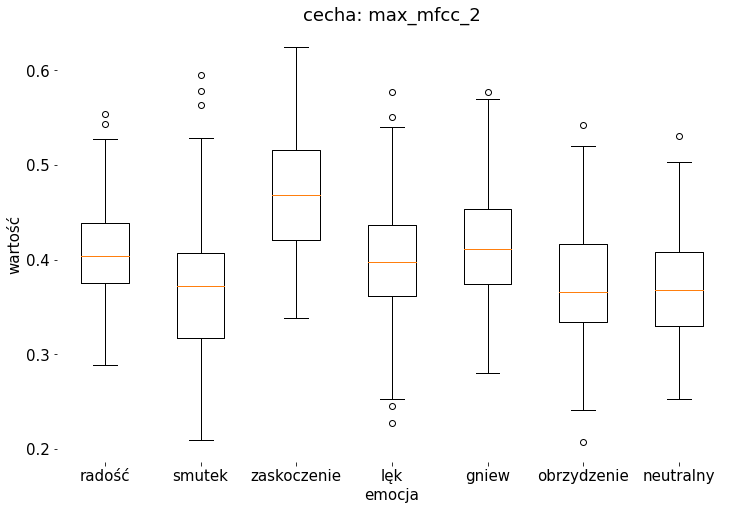

In [79]:
fig = plt.figure(figsize=(12,8))
data = best_feature.transpose()[0]
all_data = []
emotions = dataset['emotion'].unique()
display_emotions = []
for i, emotion in enumerate(emotions):
    indices = dataset[dataset['emotion'] == emotion].index
    all_data.append(data[indices])
    display_emotions.append(emotion_dictionary[emotion])
plt.rcParams.update({'font.size': 15})
plt.boxplot(all_data)
plt.xticks(range(1, len(emotions) + 1), display_emotions)
plt.xlabel('emocja')
plt.ylabel('wartość')
plt.title('cecha: ' + best_feature_name)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()

## CLASSIFIER

In [10]:
def tune_classifier_svm(dataset, train_dataset, validation_dataset, features):
    k_best = SelectKBest(f_classif)
    classifier = SVC(random_state=8)
    pipeline = Pipeline(steps=[('filter_constants', VarianceThreshold(threshold=0)), ('k_best', k_best), ('scaler', StandardScaler()), ('svm', classifier)])
    features_number = features.shape[1]

    k = ['all', int(0.9 * features_number), int(0.5 * features_number), int(0.25 * features_number)]
    C_values = [0.1, 1, 10]
    kernel = ['linear', 'poly', 'rbf']
    gamma_values = [1 / features_number] * np.array([0.1, 1, 10])
    grid_search_parameters = {
        'k_best__k': k,
        'svm__C': C_values,
        'svm__kernel': kernel,
        'svm__gamma': gamma_values
    }
    grid_search = GridSearchCV(pipeline,
                               grid_search_parameters,
                               cv=[(train_dataset.index, validation_dataset.index)],
                               n_jobs=8,
                               scoring='accuracy',
                               return_train_score=True)

    grid_search.fit(features, dataset['emotion'])
    return grid_search

def cross_validate(dataset, single_block_features, folds, validation_dataset_size, random_state):
    group_kfold = GroupKFold(n_splits=folds)
    gss = GroupShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1 / folds), random_state=random_state)
    accuracies_validation = []
    accuracies_test = []
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_validation_idx, test_idx in group_kfold.split(original_dataset, original_dataset['emotion'], original_dataset['speaker']):
        train_validation_dataset = dataset.iloc[train_validation_idx]
        test_dataset = dataset.iloc[test_idx]
        for train_idx, validation_idx in gss.split(train_validation_dataset, train_validation_dataset['emotion'], train_validation_dataset['speaker']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
        
        tune_train_dataset = train_dataset
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
        
        train_features = single_block_features[0, train_dataset.index, :]
        test_features = single_block_features[0, test_dataset.index, :]

        grid_search = tune_classifier_svm(dataset, tune_train_dataset, validation_dataset, single_block_features[0])
        classifier = grid_search.best_estimator_
        classifier.fit(train_features, train_dataset['emotion'])

        validation_accuracy = grid_search.best_score_
        accuracies_validation.append(validation_accuracy)

        predicted = classifier.predict(test_features)
        test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies_test.append(test_accuracy)
        print(validation_accuracy, test_accuracy)
    return accuracies_validation, accuracies_test

def cross_validate_memory_efficient(dataset, folds, validation_dataset_size, random_state):
    group_kfold = GroupKFold(n_splits=folds)
    gss = GroupShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1 / folds), random_state=random_state)
    accuracies_validation = []
    accuracies_test = []
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_validation_idx, test_idx in group_kfold.split(original_dataset, original_dataset['emotion'], original_dataset['speaker']):
        train_validation_dataset = dataset.iloc[train_validation_idx]
        test_dataset = dataset.iloc[test_idx]
        for train_idx, validation_idx in gss.split(train_validation_dataset, train_validation_dataset['emotion'], train_validation_dataset['speaker']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
        
        tune_train_dataset = train_dataset
        n = int(1000 / len(tune_train_dataset['emotion'].unique()) / len(tune_train_dataset['sex'].unique()))
        tune_train_dataset = tune_train_dataset.groupby(['emotion', 'sex'], as_index=False, group_keys=False).apply(lambda data: data.sample(n=n, random_state=8))
        tune_train_dataset = tune_train_dataset.reset_index()
        validation_dataset.index = range(len(tune_train_dataset), len(tune_train_dataset) + len(validation_dataset))
        tune_dataset = pd.concat([tune_train_dataset, validation_dataset])
        
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
        
        small_block_features, big_block_features, single_block_features = import_dataset_features(tune_dataset)
        grid_search = tune_classifier_svm(tune_dataset, tune_train_dataset, validation_dataset, single_block_features[0])
        
        small_block_features, big_block_features, single_block_features = import_dataset_features(train_dataset)
        train_features = single_block_features[0]
        
        small_block_features, big_block_features, single_block_features = import_dataset_features(test_dataset)
        test_features = single_block_features[0]
                
        del small_block_features
        del big_block_features
        del single_block_features
        
        classifier = grid_search.best_estimator_
        classifier.fit(train_features, train_dataset['emotion'])

        validation_accuracy = grid_search.best_score_
        accuracies_validation.append(validation_accuracy)

        predicted = classifier.predict(test_features)
        test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies_test.append(test_accuracy)
        print(validation_accuracy, test_accuracy)
    return accuracies_validation, accuracies_test

def cross_validate_speaker_dependent(dataset, single_block_features, folds, validation_dataset_size, random_state):
    kfold = KFold(n_splits=folds)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1 / folds), random_state=random_state)
    accuracies_validation = []
    accuracies_test = []
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_validation_idx, test_idx in kfold.split(original_dataset, original_dataset['emotion']):
        train_validation_dataset = dataset.iloc[train_validation_idx]
        test_dataset = dataset.iloc[test_idx]
        for train_idx, validation_idx in sss.split(train_validation_dataset, train_validation_dataset['emotion']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
            
        tune_train_dataset = train_dataset
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
        
        train_features = single_block_features[0, train_dataset.index, :]
        test_features = single_block_features[0, test_dataset.index, :]

        grid_search = tune_classifier_svm(dataset, tune_train_dataset, validation_dataset, single_block_features[0])
        classifier = grid_search.best_estimator_
        classifier.fit(train_features, train_dataset['emotion'])

        validation_accuracy = grid_search.best_score_
        accuracies_validation.append(validation_accuracy)

        predicted = classifier.predict(test_features)
        test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies_test.append(test_accuracy)
        print(validation_accuracy, test_accuracy)
    return accuracies_validation, accuracies_test

In [24]:
tune_train_dataset = train_dataset[train_dataset['augmentation'] == 'no']
grid_search = tune_classifier_svm(dataset, tune_train_dataset, validation_dataset, single_block_features[0])

In [25]:
search_results = pd.DataFrame(grid_search.cv_results_)
search_results.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_k_best__k,param_svm__C,param_svm__gamma,param_svm__kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
39,0.395896,0.0,0.036067,0.0,119,1,0.007519,linear,"{'k_best__k': 119, 'svm__C': 1, 'svm__gamma': ...",0.496154,0.496154,0.0,1,0.956731,0.956731,0.0
42,0.408455,0.0,0.027911,0.0,119,1,0.075188,linear,"{'k_best__k': 119, 'svm__C': 1, 'svm__gamma': ...",0.496154,0.496154,0.0,1,0.956731,0.956731,0.0
36,0.392107,0.0,0.035805,0.0,119,1,0.000752,linear,"{'k_best__k': 119, 'svm__C': 1, 'svm__gamma': ...",0.496154,0.496154,0.0,1,0.956731,0.956731,0.0
12,0.482699,0.0,0.038830,0.0,all,1,0.007519,linear,"{'k_best__k': 'all', 'svm__C': 1, 'svm__gamma'...",0.484615,0.484615,0.0,4,0.975962,0.975962,0.0
15,0.431134,0.0,0.023807,0.0,all,1,0.075188,linear,"{'k_best__k': 'all', 'svm__C': 1, 'svm__gamma'...",0.484615,0.484615,0.0,4,0.975962,0.975962,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.183866,0.0,0.028723,0.0,66,1,0.000752,poly,"{'k_best__k': 66, 'svm__C': 1, 'svm__gamma': 0...",0.238462,0.238462,0.0,102,0.217548,0.217548,0.0
73,0.167047,0.0,0.025631,0.0,66,10,0.000752,poly,"{'k_best__k': 66, 'svm__C': 10, 'svm__gamma': ...",0.238462,0.238462,0.0,102,0.217548,0.217548,0.0
19,0.236192,0.0,0.028329,0.0,all,10,0.000752,poly,"{'k_best__k': 'all', 'svm__C': 10, 'svm__gamma...",0.176923,0.176923,0.0,106,0.182692,0.182692,0.0
10,0.233001,0.0,0.030657,0.0,all,1,0.000752,poly,"{'k_best__k': 'all', 'svm__C': 1, 'svm__gamma'...",0.173077,0.173077,0.0,107,0.176683,0.176683,0.0


In [27]:
train_small_block_features = small_block_features[..., train_dataset.index, :]
validation_small_block_features = small_block_features[..., validation_dataset.index, :]
test_small_block_features = small_block_features[..., test_dataset.index, :]

train_big_block_features = big_block_features[..., train_dataset.index, :]
validation_big_block_features = big_block_features[..., validation_dataset.index, :]
test_big_block_features = big_block_features[..., test_dataset.index, :]

In [28]:
train_single_block_features = single_block_features[..., train_dataset.index, :]
validation_single_block_features = single_block_features[..., validation_dataset.index, :]
test_single_block_features = single_block_features[..., test_dataset.index, :]

In [29]:
print(grid_search.best_params_)
classifier = grid_search.best_estimator_
classifier.fit(train_single_block_features[0], train_dataset['emotion'])
predicted = classifier.predict(train_single_block_features[0])
print(accuracy_score(predicted, train_dataset['emotion']))
predicted = classifier.predict(test_single_block_features[0])
print(accuracy_score(predicted, test_dataset['emotion']))

{'k_best__k': 119, 'svm__C': 1, 'svm__gamma': 0.0007518796992481203, 'svm__kernel': 'linear'}
0.9567307692307693
0.44871794871794873


40% bez standaryzacji, 48% ze standaryzacją

In [178]:
accuracies_validation_single = []
accuracies_test_single = []
for i in range(0, 30):
    train_dataset, validation_dataset, test_dataset = split_dataset(dataset, i, 0.66, 0.12)
    train_features = single_block_features[0, train_dataset.index, :]
    test_features = single_block_features[0, test_dataset.index, :]
    
    tune_train_dataset = train_dataset[train_dataset['augmentation'] == 'no']
    grid_search = tune_classifier_svm(dataset, tune_train_dataset, validation_dataset, single_block_features[0])
    classifier = grid_search.best_estimator_
    classifier.fit(train_features, train_dataset['emotion'])
    
    validation_accuracy = grid_search.best_score_
    accuracies_validation_single.append(validation_accuracy)
    
    predicted = classifier.predict(test_features)
    test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
    accuracies_test_single.append(test_accuracy)
    print(i, validation_accuracy, test_accuracy)

0 0.5266666666666666 0.5993265993265994
1 0.52 0.51
2 0.54 0.5533333333333333
3 0.62 0.494949494949495
4 0.6133333333333333 0.5766666666666667
5 0.5133333333333333 0.6266666666666667
6 0.5666666666666667 0.5252525252525253
7 0.6066666666666667 0.5218855218855218
8 0.5666666666666667 0.5466666666666666
9 0.6133333333333333 0.5858585858585859
10 0.5510204081632653 0.5466666666666666
11 0.54 0.5533333333333333
12 0.54 0.45666666666666667
13 0.54 0.5566666666666666
14 0.4666666666666667 0.5925925925925926
15 0.5666666666666667 0.5633333333333334
16 0.56 0.4766666666666667
17 0.52 0.47
18 0.58 0.51
19 0.56 0.5555555555555556
20 0.56 0.51
21 0.6 0.5633333333333334
22 0.5666666666666667 0.5633333333333334
23 0.5666666666666667 0.5766666666666667
24 0.56 0.52
25 0.49333333333333335 0.5866666666666667
26 0.5933333333333334 0.5433333333333333
27 0.5986394557823129 0.51
28 0.6066666666666667 0.5566666666666666
29 0.5 0.44


In [179]:
np.save('enterface_speaker_independent_single_augmentation_66_12.npy', np.asarray(accuracies_test_single))

In [180]:
np.asarray(accuracies_test_single).mean()

0.539736251402918

In [ ]:
accuracies_validation, accuracies_test = cross_validate_speaker_dependent(dataset, single_block_features, 10, 0.2, 8)

In [21]:
accuracies_validation, accuracies_test = cross_validate_memory_efficient(dataset, 10, 0.2, 8)

0.4896907216494845 0.510840108401084
0.48646907216494845 0.592140921409214
0.5115979381443299 0.5785907859078591
0.5077419354838709 0.5311653116531165
0.5193298969072165 0.5338753387533876
0.4743260590500642 0.6002710027100271
0.49742268041237114 0.4993215739484396
0.4954896907216495 0.483695652173913
0.5044127630685675 0.46534653465346537
0.5044929396662388 0.46994535519125685


In [22]:
np.asarray(accuracies_test).mean()

0.5265192584801764

## ENSEMBLE CLASSIFIER

In [11]:
def train_ensemble_classifier(dataset, train_dataset, validation_dataset, train_input, small_block_features, big_block_features, single_block_features):
    grid_results = []
    tune_train_dataset = train_dataset[train_dataset['augmentation'] == 'no']

    for i in range(0, small_block_features.shape[0]):
        grid_results.append(tune_classifier_svm(dataset, tune_train_dataset, validation_dataset, small_block_features[i]))

    for i in range(0, big_block_features.shape[0]):
        grid_results.append(tune_classifier_svm(dataset, tune_train_dataset, validation_dataset, big_block_features[i]))

    grid_results.append(tune_classifier_svm(dataset, tune_train_dataset, validation_dataset, single_block_features[0]))

    weights = [results.best_score_ for results in grid_results]
    classifiers = [('svm' + str(index), results.best_estimator_) for index, results in enumerate(grid_results)]

    for index, classifier in enumerate(classifiers):
        if classifier[1].steps[0][0] != 'transform':
            classifier[1].steps.insert(0, ('transform', FunctionTransformer(lambda X: X[index])))
    for classifier in classifiers:
        classifier[1].steps[-1][1].probability = True

    ensemble_classifier = VotingClassifier(estimators=classifiers, voting='soft', weights=weights, n_jobs=8)
    ensemble_classifier.fit(train_input, train_dataset['emotion'])
    return ensemble_classifier

def train_ensemble_classifier_memory_efficient(dataset, train_dataset, validation_dataset):
    grid_results = []
    
    tune_train_dataset = train_dataset[train_dataset['augmentation'] == 'no']
    
    #n = int(1000 / len(tune_train_dataset['emotion'].unique()) / len(tune_train_dataset['sex'].unique()) / len(tune_train_dataset['dataset'].unique()))
    #tune_train_dataset = tune_train_dataset.groupby(['emotion', 'sex', 'dataset'], as_index=False, group_keys=False).apply(lambda data: data.sample(n=n, random_state=8))
    
    tune_train_dataset = tune_train_dataset.reset_index()
    validation_dataset_copy = validation_dataset.copy()
    validation_dataset_copy.index = range(len(tune_train_dataset), len(validation_dataset_copy) + len(tune_train_dataset))
    tune_dataset = pd.concat((tune_train_dataset, validation_dataset_copy))
    
    small_block_features, big_block_features, single_block_features = import_dataset_features(tune_dataset)
                                                                                              
    for i in range(0, small_block_features.shape[0]):
        grid_results.append(tune_classifier_svm(tune_dataset, tune_train_dataset, validation_dataset_copy, small_block_features[i]))

    for i in range(0, big_block_features.shape[0]):
        grid_results.append(tune_classifier_svm(tune_dataset, tune_train_dataset, validation_dataset_copy, big_block_features[i]))

    grid_results.append(tune_classifier_svm(tune_dataset, tune_train_dataset, validation_dataset_copy, single_block_features[0]))

    weights = [results.best_score_ for results in grid_results]
    classifiers = [('svm' + str(index), results.best_estimator_) for index, results in enumerate(grid_results)]

    for index, classifier in enumerate(classifiers):
        if classifier[1].steps[0][0] != 'transform':
            classifier[1].steps.insert(0, ('transform', FunctionTransformer(lambda X: X[index])))
    for classifier in classifiers:
        classifier[1].steps[-1][1].probability = True
    
    del small_block_features
    del big_block_features
    del single_block_features
    del tune_train_dataset
    del validation_dataset_copy
    
    train_input = np.concatenate(import_dataset_features(train_dataset))

    ensemble_classifier = VotingClassifier(estimators=classifiers, voting='soft', weights=weights, n_jobs=8)
    ensemble_classifier.fit(train_input, train_dataset['emotion'])
    return ensemble_classifier

def cross_validate_ensemble(dataset, small_block_features, big_block_features, single_block_features, folds, validation_dataset_size, random_state):
    group_kfold = GroupKFold(n_splits=folds)
    gss = GroupShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1.0 / folds), random_state=random_state)
    accuracies_validation = []
    accuracies_test = []
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_validation_idx, test_idx in group_kfold.split(original_dataset, original_dataset['emotion'], original_dataset['speaker']):
        train_validation_dataset = dataset.iloc[train_validation_idx]
        test_dataset = dataset.iloc[test_idx]
        for train_idx, validation_idx in gss.split(train_validation_dataset, train_validation_dataset['emotion'], train_validation_dataset['speaker']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
        
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
        
        train_input, validation_input, test_input = split_features(train_dataset, validation_dataset, test_dataset, small_block_features, big_block_features, single_block_features)
        ensemble_classifier = train_ensemble_classifier(dataset, train_dataset, validation_dataset, train_input, small_block_features, big_block_features, single_block_features)
        predicted = ensemble_classifier.predict(validation_input)
        validation_accuracy = accuracy_score(predicted, validation_dataset['emotion'])
        accuracies_validation.append(validation_accuracy)
        predicted = ensemble_classifier.predict(test_input)
        test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies_test.append(test_accuracy)
        print(validation_accuracy, test_accuracy)
    return accuracies_validation, accuracies_test

def cross_validate_ensemble_memory_efficient(dataset, folds, validation_dataset_size, random_state):
    group_kfold = GroupKFold(n_splits=folds)
    gss = GroupShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1.0 / folds), random_state=random_state)
    accuracies_validation = []
    accuracies_test = []
    predictions = []
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_validation_idx, test_idx in group_kfold.split(original_dataset, original_dataset['emotion'], original_dataset['speaker']):
        train_validation_dataset = dataset.iloc[train_validation_idx]
        test_dataset = dataset.iloc[test_idx]
        for train_idx, validation_idx in gss.split(train_validation_dataset, train_validation_dataset['emotion'], train_validation_dataset['speaker']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
        
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
               
        ensemble_classifier = train_ensemble_classifier_memory_efficient(dataset, train_dataset, validation_dataset)
        validation_input = np.concatenate(import_dataset_features(validation_dataset))
        test_input = np.concatenate(import_dataset_features(test_dataset))
        
        predicted = ensemble_classifier.predict(validation_input)
        validation_accuracy = accuracy_score(predicted, validation_dataset['emotion'])
        accuracies_validation.append(validation_accuracy)
        predicted = ensemble_classifier.predict(test_input)
        
        for index, prediction in enumerate(predicted):
            row = test_dataset.iloc[index]
            predictions.append([row['emotion'], prediction])
        
        test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies_test.append(test_accuracy)
        print(validation_accuracy, test_accuracy)
    return accuracies_validation, accuracies_test, predictions

def cross_validate_ensemble_speaker_dependent(dataset, small_block_features, big_block_features, single_block_features, folds, validation_dataset_size, random_state):
    kfold = KFold(n_splits=folds)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1 / folds), random_state=random_state)
    accuracies_validation = []
    accuracies_test = []
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_validation_idx, test_idx in kfold.split(original_dataset, original_dataset['emotion']):
        train_validation_dataset = dataset.iloc[train_validation_idx]
        test_dataset = dataset.iloc[test_idx]
        for train_idx, validation_idx in sss.split(train_validation_dataset, train_validation_dataset['emotion']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
        
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
        
        train_input, validation_input, test_input = split_features(train_dataset, validation_dataset, test_dataset, small_block_features, big_block_features, single_block_features)
        ensemble_classifier = train_ensemble_classifier(dataset, train_dataset, validation_dataset, train_input, small_block_features, big_block_features, single_block_features)
        predicted = ensemble_classifier.predict(validation_input)
        validation_accuracy = accuracy_score(predicted, validation_dataset['emotion'])
        accuracies_validation.append(validation_accuracy)
        predicted = ensemble_classifier.predict(test_input)
        test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies_test.append(test_accuracy)
        print(validation_accuracy, test_accuracy)
    return accuracies_validation, accuracies_test

def cross_validate_ensemble_memory_efficient_speaker_dependent(dataset, folds, validation_dataset_size, random_state):
    kfold = KFold(n_splits=folds)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1.0 / folds), random_state=random_state)
    accuracies_validation = []
    accuracies_test = []
    predictions = []
    original_dataset = dataset[dataset['augmentation'] == 'no']
    for train_validation_idx, test_idx in kfold.split(original_dataset, original_dataset['emotion'], original_dataset['speaker']):
        train_validation_dataset = dataset.iloc[train_validation_idx]
        test_dataset = dataset.iloc[test_idx]
        for train_idx, validation_idx in sss.split(train_validation_dataset, train_validation_dataset['emotion']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
        
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
               
        ensemble_classifier = train_ensemble_classifier_memory_efficient(dataset, train_dataset, validation_dataset)
        validation_input = np.concatenate(import_dataset_features(validation_dataset))
        test_input = np.concatenate(import_dataset_features(test_dataset))
        
        predicted = ensemble_classifier.predict(validation_input)
        validation_accuracy = accuracy_score(predicted, validation_dataset['emotion'])
        accuracies_validation.append(validation_accuracy)
        predicted = ensemble_classifier.predict(test_input)
        
        for index, prediction in enumerate(predicted):
            row = test_dataset.iloc[index]
            predictions.append([row['emotion'], prediction])
        
        test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies_test.append(test_accuracy)
        print(validation_accuracy, test_accuracy)
    return accuracies_validation, accuracies_test, predictions

def leave_one_corpus_out(dataset, validation_dataset_size, random_state):
    accuracies = []
    corpora = dataset['dataset'].unique()
    
    gss = GroupShuffleSplit(n_splits=1, train_size=1 - validation_dataset_size / (1 - 1 / len(corpora)), random_state=random_state)
    original_dataset = dataset[dataset['augmentation'] == 'no']
    predictions = []
    for corpus in corpora:
        test_dataset = original_dataset[original_dataset['dataset'] == corpus]
        train_validation_dataset = original_dataset.drop(test_dataset.index)
        for train_idx, validation_idx in gss.split(train_validation_dataset, train_validation_dataset['emotion'], train_validation_dataset['dataset']):
            train_dataset = train_validation_dataset.iloc[train_idx]
            validation_dataset = train_validation_dataset.iloc[validation_idx]
        
        augmented_dataset = dataset[(dataset['augmentation'] != 'no') & (dataset['original_id'].isin(train_dataset['id']))]
        train_dataset = pd.concat([train_dataset, augmented_dataset])
        
        ensemble_classifier = train_ensemble_classifier_memory_efficient(dataset, train_dataset, validation_dataset)
        test_input = np.concatenate(import_dataset_features(test_dataset))
        
        predicted = ensemble_classifier.predict(test_input)
        accuracy = accuracy_score(predicted, test_dataset['emotion'])
        accuracies.append(accuracy)
        
        for index, prediction in enumerate(predicted):
            row = test_dataset.iloc[index]
            predictions.append([row['dataset'], row['emotion'], prediction])
            
        print(accuracy)
            
    return accuracies, predictions

In [74]:
ensemble_classifier = train_ensemble_classifier(dataset, train_dataset, validation_dataset, train_input, small_block_features, big_block_features, single_block_features)

In [75]:
predicted = ensemble_classifier.predict(validation_input)
accuracy_score(predicted, validation_dataset['emotion'])

0.5153846153846153

In [76]:
predicted = ensemble_classifier.predict(test_input)

accuracy_score(predicted, test_dataset['emotion'])

0.5384615384615384

In [175]:
accuracies_validation = []
accuracies_test = []
for i in range(0, 30):
    train_dataset, validation_dataset, test_dataset = split_dataset(dataset, i, 0.66, 0.12)
    train_input, validation_input, test_input = split_features(train_dataset, validation_dataset, test_dataset, small_block_features, big_block_features, single_block_features)
    ensemble_classifier = train_ensemble_classifier(dataset, train_dataset, validation_dataset, train_input, small_block_features, big_block_features, single_block_features)
    
    #ensemble_classifier = train_ensemble_classifier_memory_efficient(dataset, train_dataset, validation_dataset)
    #test_input = np.concatenate(import_dataset_features(test_dataset))
    #validation_input = np.concatenate(import_dataset_features(validation_dataset))
    
    predicted = ensemble_classifier.predict(validation_input)
    validation_accuracy = accuracy_score(predicted, validation_dataset['emotion'])
    accuracies_validation.append(validation_accuracy)
    predicted = ensemble_classifier.predict(test_input)
    test_accuracy = accuracy_score(predicted, test_dataset['emotion'])
    accuracies_test.append(test_accuracy)
    print(i, validation_accuracy, test_accuracy)

0 0.52 0.6296296296296297
1 0.5733333333333334 0.5233333333333333
2 0.5533333333333333 0.57
3 0.66 0.6094276094276094
4 0.6466666666666666 0.5866666666666667
5 0.5 0.65
6 0.49333333333333335 0.5555555555555556
7 0.64 0.531986531986532
8 0.5266666666666666 0.57
9 0.64 0.5993265993265994
10 0.5714285714285714 0.5566666666666666
11 0.5466666666666666 0.5933333333333334
12 0.49333333333333335 0.56
13 0.5133333333333333 0.57
14 0.46 0.6026936026936027
15 0.6533333333333333 0.5966666666666667
16 0.58 0.54
17 0.5266666666666666 0.53
18 0.6 0.5066666666666667
19 0.5933333333333334 0.5858585858585859
20 0.6133333333333333 0.55
21 0.6066666666666667 0.56
22 0.6133333333333333 0.56
23 0.6066666666666667 0.5866666666666667
24 0.5333333333333333 0.5333333333333333
25 0.5266666666666666 0.61
26 0.5466666666666666 0.58
27 0.5986394557823129 0.5366666666666666
28 0.6133333333333333 0.57
29 0.5 0.49666666666666665


In [176]:
np.save('enterface_speaker_independent_ensemble_augmentation_66_12.npy', np.asarray(accuracies_test))

In [177]:
np.asarray(accuracies_test).mean()

0.5683714927048259

47% dla pojedynczego klasyfikatora, 49% dla klasyfikatora zbiorowego

In [ ]:
accuracies_validation, accuracies_test = cross_validate_ensemble(dataset, small_block_features, big_block_features, single_block_features, 10, 0.2, 8)

In [184]:
accuracies_validation, accuracies_test, predictions = cross_validate_ensemble_memory_efficient(dataset, 10, 0.2, 8)

0.776 0.784
0.776 0.72
0.744 0.76
0.748 0.728
0.752 0.72
0.768 0.72
0.8 0.728
0.808 0.68
0.8 0.7741935483870968
0.78 0.8306451612903226


In [186]:
np.asarray(accuracies_test).mean()

0.7444838709677419

In [79]:
accuracies, predictions = leave_one_corpus_out(dataset, 0.2, 8)

0.28
0.29
0.30666666666666664
0.44333333333333336
0.34


In [80]:
np.asarray(accuracies).mean()

0.332

In [79]:
np.save('predictions_leave_one.npy', predictions)
np.save('accuracies_leave_one.npy', accuracies)

In [20]:
predictions = np.load('predictions_leave_one.npy')
accuracies = np.load('accuracies_leave_one.npy')

In [37]:
predictions2 = np.load('predictions_ravdess.npy')
predictions3 = np.load('predictions_ravdess_speaker_dependent.npy')

In [21]:
true = [prediction[0] for prediction in predictions]
predicted = [prediction[1] for prediction in predictions]

In [5]:
def get_class_accuracies(predictions):
    emotions = dataset['emotion'].unique()
    hit_counts = dict((emotion, 0) for emotion in emotions)
    emotion_counts = dict((emotion, 0) for emotion in emotions)
    for prediction in predictions:
        if prediction[0] == prediction[1]:
            hit_counts[prediction[0]] += 1
        emotion_counts[prediction[0]] += 1

    class_accuracies = []
    for emotion in emotions:
        class_accuracies.append(hit_counts[emotion] / emotion_counts[emotion] if emotion_counts[emotion] != 0 else 0)
    return class_accuracies

In [49]:
class_accuracies1 = get_class_accuracies(predictions)
class_accuracies2 = get_class_accuracies(predictions2)
class_accuracies3 = get_class_accuracies(predictions3)

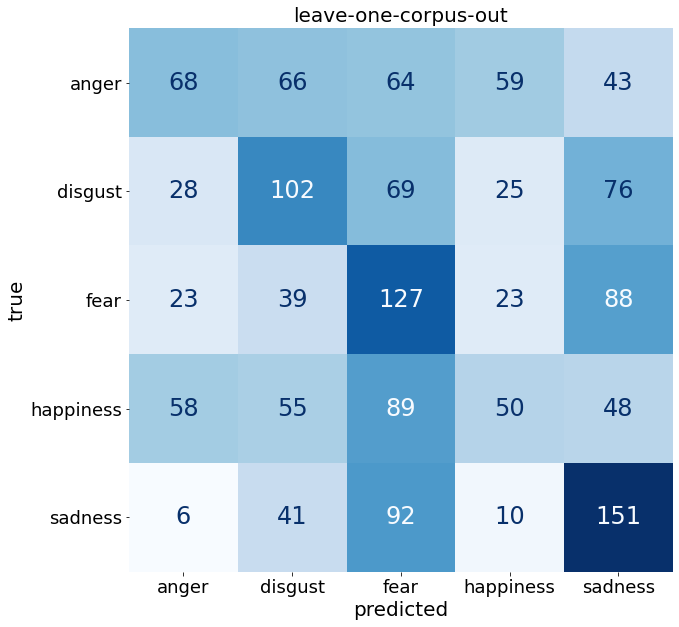

In [23]:
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(15,10))
display_emotions = [emotion_dictionary[emotion] for emotion in dataset['emotion'].unique()]
plot = ConfusionMatrixDisplay(confusion_matrix(true, predicted, labels=dataset['emotion'].unique()), display_labels=dataset['emotion'].unique())
plt.rcParams.update({'font.size': 24})
plot.plot(ax=ax, cmap='Blues')

im = ax.images
cb = im[-1].colorbar
#cb.outline.set_visible(False)
cb.remove()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.xlabel('predicted', fontsize=20)
plt.ylabel('true', fontsize=20)
plt.title('leave-one-corpus-out', fontsize=20)
plt.show()

In [26]:
fig.savefig('leave_one_corpus_out_confusion_matrix.eps', format='eps', bbox_inches='tight')

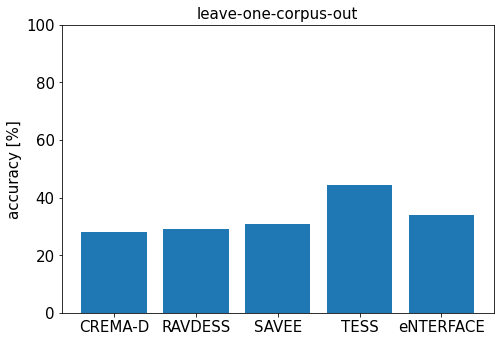

In [18]:
percentages = [accuracy * 100 for accuracy in accuracies]
plt.rcParams.update({'font.size': 15})
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(corpora, percentages)
ax.set_ylim((0, 100))
ax.set_ylabel('accuracy [%]', fontsize=15)
ax.set_title('leave-one-corpus-out', fontsize=15)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.show()

In [28]:
all_corpus_emotions = dataset['emotion'].unique()

In [30]:
accuracies_set = [accuracies3, accuracies2]

In [86]:
row1, row2 = df.iloc[0], df.iloc[2]
tmp = df.iloc[0].copy()
df.iloc[0] = row2
df.iloc[2] = tmp

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


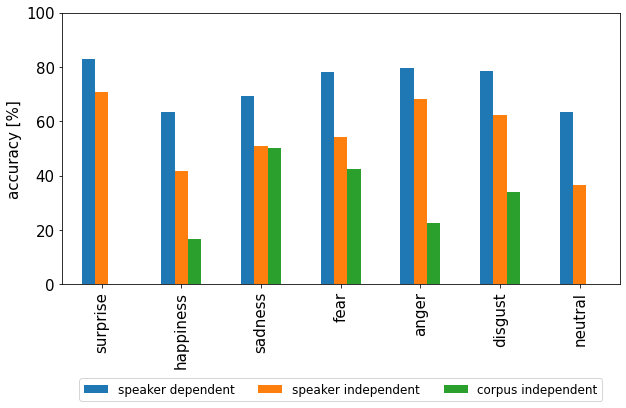

In [119]:
percentages1 = [accuracy * 100 for accuracy in class_accuracies1]
percentages2 = [accuracy * 100 for accuracy in class_accuracies2]
percentages3 = [accuracy * 100 for accuracy in class_accuracies3]
plt.rcParams.update({'font.size': 15})
df = pd.DataFrame(np.c_[percentages3, percentages2, percentages1], index=dataset['emotion'].unique())
df = df.loc[['surprise', 'happiness', 'sadness', 'fear', 'anger', 'disgust', 'neutral']]
ax = df.plot.bar(figsize=(10, 5))

# percentages = [accuracy * 100 for accuracy in class_accuracies]
# fig = plt.figure()
# ax = fig.add_axes([0, 0, 1, 1])
# ax.bar(dataset['emotion'].unique(), percentages)
ax.set_ylim((0, 100))
ax.set_ylabel('accuracy [%]', fontsize=15)
#ax.set_title('leave-one-corpus-out', fontsize=15)
ax.legend(['speaker dependent', 'speaker independent', 'corpus independent'], loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=3, fontsize=12)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.savefig('class_accuracies.eps', format='eps', bbox_inches='tight')
plt.show()

In [56]:
val = 0.9062
sample1 = np.load('enterface_speaker_independent_single_66_12.npy')
sample2 = np.load('enterface_speaker_independent_single_augmentation_66_12.npy')
sample3 = np.load('enterface_speaker_independent_ensemble_66_12.npy')
sample4 = np.load('enterface_speaker_independent_ensemble_augmentation_66_12.npy')

In [57]:
t_val, p_val = stats.ttest_rel(sample2, sample1, alternative='greater')
print('sample2 > sample1:', t_val, p_val)
t_val, p_val = stats.ttest_rel(sample4, sample3, alternative='greater')
print('sample4 > sample3:', t_val, p_val)
t_val, p_val = stats.ttest_rel(sample3, sample1, alternative='greater')
print('sample3 > sample1:', t_val, p_val)
t_val, p_val = stats.ttest_rel(sample4, sample2, alternative='greater')
print('sample4 > sample2:', t_val, p_val)

sample2 > sample1: 4.7509011562127315 2.5337117751871393e-05
sample4 > sample3: 6.436452232474719 2.422851534284953e-07
sample3 > sample1: 4.301277678523077 8.779741758484236e-05
sample4 > sample2: 5.6347443803974855 2.178538852947842e-06


In [58]:
t_val, p_val = stats.ttest_1samp(sample4, val, alternative='greater')
print('sample4 > val:', t_val, p_vals)

sample4 > val: -52.38976908052134 1.0
